In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['yelp_academic_dataset_business.json', 'yelp_academic_dataset_user.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'Dataset_Challenge_Dataset_Agreement.pdf']


# Measuring the impact of negative Yelp reviews on businesses
Siddharth Garimella




I grew up in a neighborhood in which quite a few businesses came and went in the blink of an eye. Either they resonated with nearby residents, joining a select few other local mainstays, or they would swiftly be forced to close.

With the advent of online rating platforms such as Yelp, however, I believe the margin of error for many small businesses has decreased even further. Yelp is becoming an increasingly popular platform for prospective consumers to choose where to spend their money, and it is more and more important for many new businesses on Yelp to maintain a good average rating.

But what happens when the ratings are bad? Do bad average ratings early on in a company's Yelp page deter customers enough to make a measurable financial impact on the business? To answer these questions, I'm going to run a Survival Analysis using the Yelp academic dataset (easily downloaded from Kaggle's website, contains information about > 100k stores), and measure the times from the first Yelp review made for a store to the store's closure (if the store is closed).

### Loading Data

The data used for this project is the yelp academic dataset, publicly available on Kaggle here: https://www.kaggle.com/yelp-dataset/yelp-dataset. The dataset contains ~5.2M reviews about ~174k businesses, and is quite large. 

In [3]:
businesses = pd.read_json('../input/yelp_academic_dataset_business.json', lines = True)
businesses.head(5)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


There are a ridiculous number of reviews in this dataset. Without reading the data in chunks, Pandas throws errors. For the sake of development initially, I'll just load a small fraction of the dataset, as running my algorithms on the entire dataset could likely take a lot of time.

In [57]:
def get_review_datachunk(n):
    reviews = pd.read_json('../input/yelp_academic_dataset_review.json', lines = True, chunksize=n);
    review_data = []
    clim = 1
    i = 0
    for chunk in reviews:
        if i < clim:
            review_data.append(chunk)
            i+=1
        else:
            break
    review_data[0].head(5)
    return review_data[0]

reviews = get_review_datachunk(1000);
reviews.head(5)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


### Understanding the data

I'll define what makes a "good" review and a "bad" review based on the review star count. This threshold is a bit arbitrary, but can provide some early insights about the data before further analysis. 

In [101]:
good_review_threshold = 4

businesses_good_reviews = businesses[businesses['stars'] >= good_review_threshold]
businesses_bad_reviews = businesses[businesses['stars'] < good_review_threshold]

The "is_open" column value is 1 if a business is open and 0 if a business is closed. This lets us easily determine how many businesses are open and closed.

In [102]:
businesses_good_reviews['is_open'].describe()

count    91486.000000
mean         0.850021
std          0.357053
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: is_open, dtype: float64

In [103]:
businesses_bad_reviews['is_open'].describe()

count    101123.000000
mean          0.798631
std           0.401025
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_open, dtype: float64

There appears to be a little difference in closings between businesses we defined to have good reviews and the others. Interesting. I'll learn a little bit about the average number of reviews left at "good" and "bad" places next.

In [104]:
businesses_good_reviews['review_count'].describe()

count    91486.000000
mean        38.923639
std        129.525290
min          3.000000
25%          4.000000
50%          9.000000
75%         26.000000
max       8348.000000
Name: review_count, dtype: float64

In [105]:
businesses_bad_reviews['review_count'].describe()

count    101123.000000
mean         28.667445
std          88.745459
min           3.000000
25%           4.000000
50%           9.000000
75%          24.000000
max        6708.000000
Name: review_count, dtype: float64

It seems that places with good reviews have more reviews on average than places with bad reviews. 

### Analyzing the distribution of ratings

The stats from earlier were a bit vague, and there's a lot of information packed in there. To simplify things, I'll learn about the distribution of ratings by using a histogram.

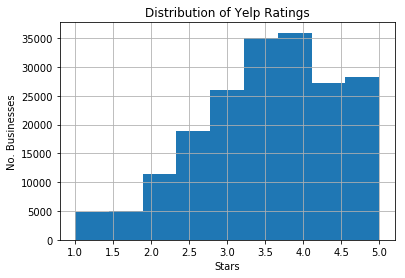

In [107]:
plt.figure();
dfs = businesses['stars'].sort_values();
dfs.hist(bins=9);
plt.xlabel('Stars');
plt.ylabel('No. Businesses');
plt.title('Distribution of Yelp Ratings');

### Structuring the Survival analysis

So I have a business dataframe and a reviews dataframe. The business dataframe tells me if businesses are open or closed, and associates each business with a "business_id", which I can use to query all the reviews for that business in the reviews dataframe. 

The basic element of any survival analysis is knowledge of lifespans. In my case, it's knowledge regarding how long a business was open. Explicitly, the yelp dataset does not provide this information. So how will I conduct my survival analysis? Here's my plan.

#### Drop duplicate businesses

It's safe to assume most businesses on Yelp are customer facing; that's why they're there. It isn't safe to assume most businesses are at equal risks of closing. Businesses that have been around for a long time, and franchises are likely to mess with the data we're looking at (poorly rated, at-risk-of-closing businesses). There could be 50 KFC's, for example, all with 2 stars in this dataset, refusing to close. Due to class size and outlier financial stability, we will attempt to remove these businesses by simply removing businesses with the same name from the Yelp business list. FYI, there are about 50k of them.

#### Calculate "Yelp lifespan"

For the remaining businesses, we can get the earliest and latest Yelp reviews and get their difference in days to "guess" their lifespan. The data is left-censored, so one idea here is to do this only for businesses with an earliest Yelp review after 2008.

#### Make CDF for open businesses by lifespan

The simplest way to kick off the survival analysis is by finding the CDF, at which point deriving the survival curve is not super difficult. This process can be done with businesses for each average star rating bracket, and we might be able to find out if between some lifespans there does exist a difference in the number of open stores or not.

In [110]:
# To get earliest/latest review dates for lifespan approximation, dates must be converted to datetime objects
reviews['date_formed'] = reviews['date']
reviews['date_time'] =  pd.to_datetime(reviews['date_formed'])
reviews['date_time'].min()

Timestamp('2004-12-19 20:56:54')

^ Hey, that's pretty early. Looks like we should really consider only running with businesses with reviews starting after 2008 (or some later date). I'm currently testing on a small fraction of the data though, so dropping a subset of the few businesses I have to work with could make development and analysis really difficult. I'll deal with the left-censorship issue later.

In [127]:
# Drop duplicates
def get_unique_businesses(businesses):
    sunq = businesses.drop_duplicates(subset='name')
    return sunq

# Calculate Yelp lifespans
def get_earliest_review(reviews, bid):
    return reviews[reviews['business_id'].values==bid]['date_time'].min()

def get_latest_review(reviews,bid):
    return reviews[reviews['business_id'].values==bid]['date_time'].max()

def get_yelp_lifespan(bid):
    x = (get_latest_review(reviews,bid) - get_earliest_review(reviews,bid)).days
    if isinstance(x, int) and x > 0:
        return x
    else:
        return -1

def calculate_earliests(businesses, reviews):
    businesses['earliest'] = -1
    for i, row in businesses.iterrows():
        bid = row['business_id']
        businesses.at[i,'earliest'] = get_earliest_review(reviews, bid)
    return businesses[(businesses['earliest'] != -9223372036854775808) & (businesses['earliest'] != np.datetime64('NaT')) & (businesses['earliest'] != -1)]

def calculate_yelp_lifespans(businesses):
    businesses['lifespan'] = -1
    for i, row in businesses.iterrows():
        bid = row['business_id']
        businesses.at[i,'lifespan'] = get_yelp_lifespan(bid)
    return businesses

I'm curious to know if there is actually any serious change in the distribution after removing duplicates.

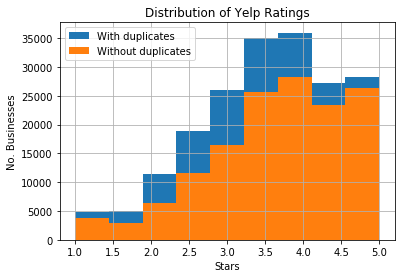

In [116]:
unique_businesses = get_unique_businesses(businesses)
plt.figure();
dfs = unique_businesses['stars'].sort_values();
businesses['stars'].hist(bins=9);
dfs.hist(bins=9);
plt.xlabel('Stars');
plt.ylabel('No. Businesses');
plt.title('Distribution of Yelp Ratings');
plt.legend(["With duplicates","Without duplicates"])

Nope.

In [128]:
unique_businesses = calculate_earliests(unique_businesses, reviews)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
unique_businesses.dropna(inplace=True)
unique_businesses.head()

In [138]:
unique_businesses['lifespan'] = -1
for i, row in unique_businesses.iterrows():
    bid = row['business_id']
    unique_businesses.at[i,'lifespan'] = get_yelp_lifespan(bid)

In [139]:
unique_businesses_lives = unique_businesses[unique_businesses['lifespan'] != -1]
unique_businesses_lives.head(5)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,earliest,lifespan
78,"13843 N Tatum Blvd, Ste 15","{'Caters': 'True', 'GoodForKids': 'True', 'Noi...",44YFU284Z3KDEy25QyVoUw,"Chinese, Restaurants",Phoenix,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1,33.613020,-111.977036,Nee House Chinese Restaurant,85032,269,3.5,AZ,2012-04-28 21:08:22,1747
159,322 Adelaide Street W,"{'Alcohol': 'u'beer_and_wine'', 'BikeParking':...",c35qzLN6ItDpVIoj2uQW4Q,"Soup, Restaurants, Sandwiches",Toronto,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,43.647585,-79.392032,Ravi Soups,M5V 1R1,332,4.5,ON,2014-02-23 22:52:13,860
162,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"Seafood, Restaurants",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",1,33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ,2017-05-26 02:22:41,347
288,3131 Las Vegas Blvd S,"{'BusinessParking': '{'garage': True, 'street'...",_pBXtjN43eqMV0XZTz7nmw,"Music Venues, Dance Clubs, Arts & Entertainmen...",Las Vegas,"{'Wednesday': '22:30-4:0', 'Friday': '22:30-4:...",0,36.129243,-115.165644,Encore Beach Club at Night,89109,865,3.5,NV,2012-02-01 02:11:56,307
679,162 Danforth Avenue,"{'GoodForMeal': '{'dessert': False, 'latenight...",q8MUVVuQpfR6v0HBHmAFxw,"Canadian (New), Bakeries, Restaurants, Food, B...",Toronto,"{'Wednesday': '11:30-23:0', 'Thursday': '11:30...",0,43.676642,-79.357421,The Combine Eatery,M4K 1N2,82,3.5,ON,2011-08-24 20:33:39,857


### Creating CDF's

Finally, we have all the data required to start making some helpful plots. I'm making CDF's for every star bracket, and then looking at which rating tier has big lifespan distribution differences.

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


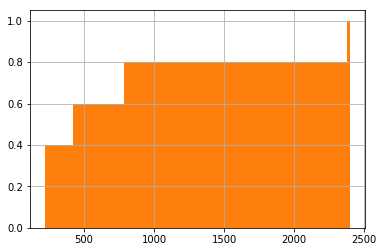

In [142]:
unique_businesses_lives[(unique_businesses_lives['stars'] == 5) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] == 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] == 3) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] <= 2) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)

That really failed. If you go to the top of this notebook you may find that there is just not much data for the lower star businesses, especially in the slice I have working right now. This problem will undoubtedly be resolved by taking a larger chunk of reviews out of the dataset, but for a start I'll just define good businesses as exceptionally good businesses, with 4 or more stars. 

Text(0, 0.5, 'Probability')

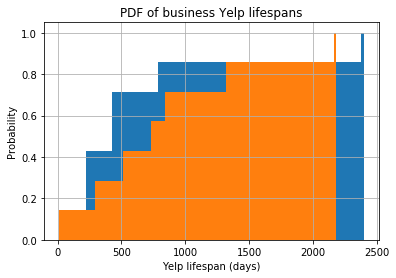

In [147]:
plt.figure()
unique_businesses_lives[(unique_businesses_lives['stars'] >= 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
unique_businesses_lives[(unique_businesses_lives['stars'] < 4) & (unique_businesses_lives['is_open'] == 0)]['lifespan'].hist(cumulative=True, density=1, bins=100)
plt.title("PDF of business Yelp lifespans")
plt.xlabel("Yelp lifespan (days)")
plt.ylabel("Probability")

This is something. For businesses with lifespans between one and three years there does exist a difference in probability of closure. 

I need to do three things from there. First, I need to go back and use more data. Second, I need to try and figure out the left-censorship issue. Third, I need to generate visuals that portray my findings cleanly. 

Finally, I'm aware that this notebook draft isn't very content heavy, but a lot of challenges on this project came with the size of my dataset, and my little knowledge of pandas didn't help. Figuring out I needed to chunk the review dataset took time figuring out, and iterating through the businesses list and finding the earliest and latest yelp review for each one just has a high runtime. These things made development get in the way of my data analysis this project, and I'm aware there's a fair amount of work left to be done here.